<a href="https://colab.research.google.com/github/TWAAXOne/Network-intrusion-detection-with-machine-learning/blob/main/CNN_Mutliclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mise en place du modèle permettant de prédire la catégorie d'une attaque réseau
Grace à ce modèle, nous allons pouvoir prédire la catégorie d'une attaque réseau en fonction de ses caractéristiques.
Nous allons utilisé le fichier csv précédemment créé dans le script "prepare_data_CNN". Les données sont déjà préparées pour être utilisées dans un modèle de réseau de neurones.

## Importation des librairies

In [ ]:
# Forcer l'utilisation de Tensorflow 2.x
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
# Install les packages nécessaires
!pip install bayesian-optimization
!pip install mlxtend --upgrade --no-deps

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras import Model
from keras.layers import Input
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix
# Ordinateur Local
# from keras.src.layers import BatchNormalization, ReLU, Conv2D, Flatten, Dense, concatenate, MaxPooling2D, Dropout

# Google Colab
from google.colab import drive
from tensorflow.keras.layers import BatchNormalization, ReLU, Conv2D, Flatten, Dense, concatenate, MaxPooling2D, Dropout


## Importation des données

In [ ]:
# Import des données Local
# data = pd.read_csv('all_data_UNSW-NB15.csv', low_memory=False)

In [ ]:
# Import des données sur Google Colab
# Récupérer son drive Google
drive.mount('/content/drive')
# Path
path_data = "/content/drive/MyDrive/Data/all_data_UNSW-NB15.csv"

# Import des données
data = pd.read_csv(path_data,dtype='float')

Mounted at /content/drive


## Affichage des données

In [ ]:
data.head()

,proto,state,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,service,...,attack_cat_analysis,attack_cat_backdoor,attack_cat_dos,attack_cat_exploits,attack_cat_fuzzers,attack_cat_generic,attack_cat_normal,attack_cat_reconnaissance,attack_cat_shellcode,attack_cat_worms
0,120.0,2.0,0.0,0.0,0.0,31.0,29.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,120.0,2.0,0.0,0.0,0.0,31.0,29.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,120.0,2.0,0.0,0.0,0.0,31.0,29.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,120.0,2.0,0.0,0.0,0.0,31.0,29.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,120.0,2.0,0.0,0.0,0.0,31.0,29.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Récupération de la valeur de la variable cible

In [ ]:
# Définition de 'y' en fonction des colonnes d'encodage one-hot
y_cols = ['attack_cat_analysis', 'attack_cat_backdoor', 'attack_cat_dos', 'attack_cat_exploits', 'attack_cat_fuzzers',
          'attack_cat_generic', 'attack_cat_normal', 'attack_cat_reconnaissance', 'attack_cat_shellcode',
          'attack_cat_worms']

y = data[y_cols]

# Extraction des colonnes "attack_cat" pour les stocker dans 'y'
# y = data[y_cols]
# Conversion de 'y' en tableau numpy
#y_values = y.values
# Récupération des noms des colonnes
#y_columns = y.columns

# Suppression des colonnes d'encodage one-hot après avoir défini 'y'
data.drop(y_cols, axis=1, inplace=True)

In [ ]:
# suppression de la colonne 'label'
data.drop('label', axis=1, inplace=True)

## Affichage des données en images

In [ ]:
# La longueur de notre dataset est de 42 colonnes et de 257673 lignes
print(data.shape)

(2540047, 43)


In [ ]:
# Chaque ligne aura une longueur de 64 valeurs
# Actuellement, chaque ligne est composée de 43 valeurs donc nous ajoutons 21 valeurs pour arriver à 64
# (0,0) : 0 ligne ajoutée en haut, 0 ligne ajoutée en bas
# (0,22) : 0 colonne ajoutée à gauche, 22 colonnes ajoutées à droite
# 'constant' : Les valeurs ajoutées sont des 0
byte_images = np.pad(data.to_numpy(), ((0, 0), (0, 21)), 'constant')
print(byte_images.shape)

(2540047, 64)


Image normale :
Normal Output


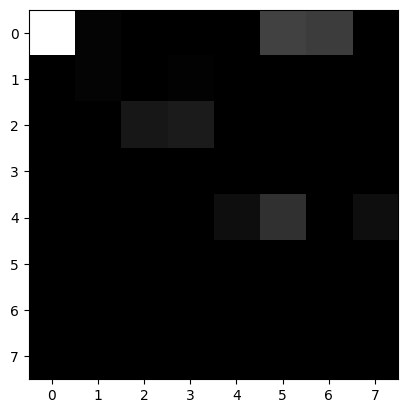

Generic Output


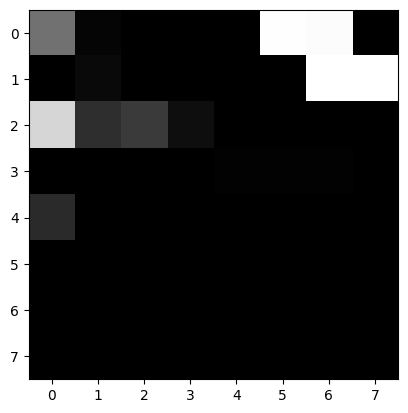

Exploits Output


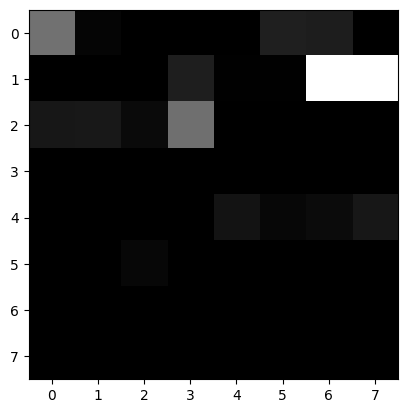

Fuzzers Output


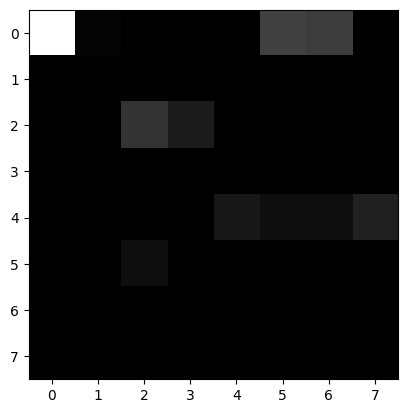

DoS Output


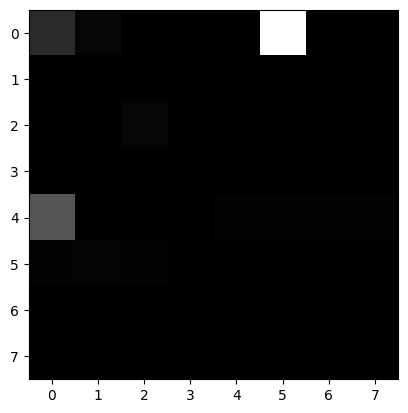

Reconnaissance Output


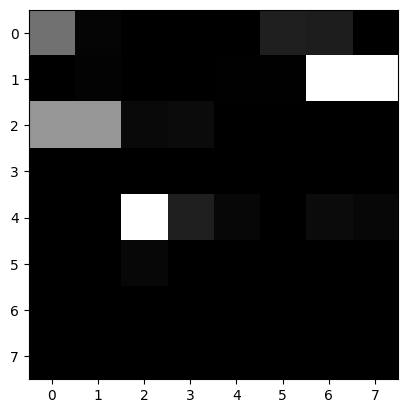

Analysis Output


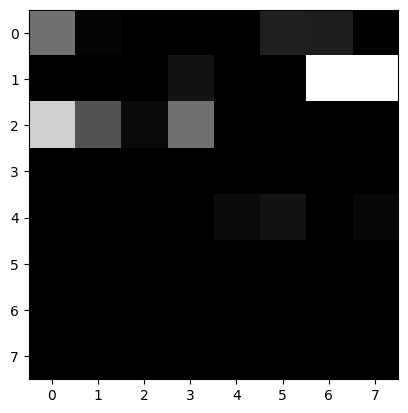

Backdoor Output


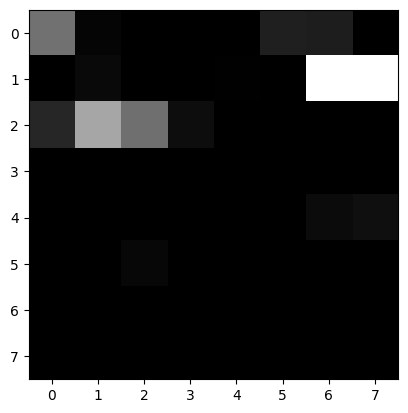

Shellcode Output


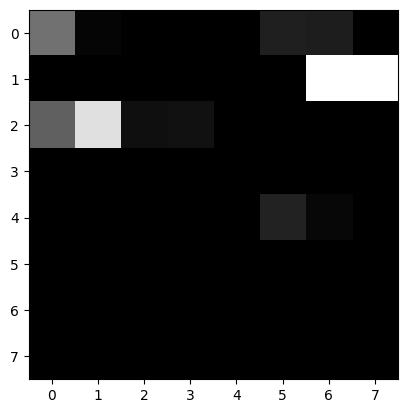

Worms Output


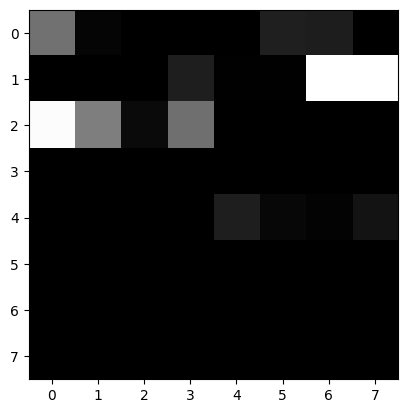

In [ ]:
# Plot d'une image
def plot_single_image(byte_image):
    grayImage = byte_image.reshape(8, 8)  # On redimensionne l'image
    plt.imshow(grayImage, cmap="gray")  # On affiche l'image avec une colormap en niveau de gris
    plt.show()  # On affiche l'image


print("Image normale :")
print("Normal Output")
plot_single_image(byte_images[0])  # index 0 = Normal
print("Generic Output")
plot_single_image(byte_images[117204])
print("Exploits Output")
plot_single_image(byte_images[48932])
print("Fuzzers Output")
plot_single_image(byte_images[48017])
print("DoS Output")
plot_single_image(byte_images[48999])
print("Reconnaissance Output")
plot_single_image(byte_images[48866])
print("Analysis Output")
plot_single_image(byte_images[47932])
print("Backdoor Output")
plot_single_image(byte_images[47911])
print("Shellcode Output")
plot_single_image(byte_images[48813])
print("Worms Output")
plot_single_image(byte_images[49959])

In [ ]:
# Normaliser les données de -0.5 à 0.5
# Après plusieurs test, l'entrainement ce fait plus rapidement après la normalisation
# Car l'algorithme de descente de gradient converge plus rapidement
x = []
for image in np.array(byte_images):
    x.append((image / 255 - 0.5)) # Normalisation des valeurs entre -0.5 et 0.5

# Transformation de x en matrice
x = np.array(x)
# x.shape = (930'000, 64)
x = x.reshape(x.shape[0], 8, 8, 1)
# Transforme le vecteur x en une matrice 4D de taille (930'000, 8, 8, 1)
# chaque element de la liste x est un vecteur de taille 64, nous la transformons en un carré donc 8x8.
# 1 car nous avons une seule couleur (niveau de gris)


In [ ]:
# Récupération des valeurs de 'byte_images' dans 'x'
x = np.array(byte_images)
x.shape

(2540047, 64)

In [ ]:
x = x.reshape(data.shape[0], 8, 8, 1)
# Transforme le vecteur x en une matrice 4D de taille (2'540'047, 8, 8, 1)
# chaque element de la liste x est un vecteur de taille 64, nous la transformons en un carré donc 8x8x1.
# 1 car nous avons une seule couleur (niveau de gris)

In [ ]:
def plot_accuracies(nets, history, names, y_accuracy):
    """
    Affiche un graphique des précisions de validation pour différents modèles
    sur plusieurs époques d'entraînement.

    :param nets: Nombre total de modèles à afficher.
    :param history: Liste contenant l'historique d'entraînement pour chaque modèle.
    :param names: Liste des noms des modèles.
    :param y_accuracy: Limites pour l'axe des ordonnées (précision).
    """
    # Initialisation de la figure
    plt.figure(figsize=(15, 5))
    # Liste de couleurs pour les différentes courbes
    color = ['red', 'green', 'blue', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
    # Boucle pour tracer la précision de validation pour chaque modèle
    for i in range(nets):
        plt.plot(history[i].history['val_accuracy'], linestyle='--', color=color[i])
    # Titre et étiquettes pour les axes
    plt.title('Précision du modèle')
    plt.ylabel('Précision')
    plt.xlabel('Époque')
    # Légende du graphique
    plt.legend(names, loc='upper left')
    # Configuration de l'axe des ordonnées et activation de la grille
    axes = plt.gca()
    axes.set_ylim(y_accuracy)
    plt.grid(True)
    # Affichage du graphique
    plt.show()


### Séparation des données en train et test (Stratifié pour dataset déséquilibré)
Utilisation de la validation stratifiée pour séparer les données en train et test. Car nous avons un dataset déséquilibré.
Malheureusement, nous n'allons pas pouvoir utiliser la validation croisée car cela prendrait trop de temps et de ressources.

In [ ]:
# Séparation des données en données d'entraînement et données de test
# StratifiedShuffleSplit permet de conserver la même proportion de classes dans les données d'entraînement et de test
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

for train_index, test_index in sss.split(x, y):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Création du modèle
## Quel est la structure du modèle idéal ?

In [ ]:
nb_classes = y.shape[1]  # Nombre de classes
print(nb_classes)

10


In [34]:
nets = 5  # Nombre de modèle
model = [0] * nets  # Liste des modèles
history = [0] * nets  # Liste des historiques d'entraînement pour chaque modèle
names = ["ClassicConvNet", "NormedConvNet", "MiniVGGNet", "GoogleNet", "DenseNet"]  # Noms des modèles

epochs = 5  # Nombre d'époques d'entraînement
batch_size = 128  # Taille du lot

# Boucle pour créer les modèles
for net in range(nets):
    input_img = Input(shape=(8, 8, 1))  # Définition de la taille des images en entrée
    if net == 0:  # ClassicConvNet
        # Bloc 1
        block_1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
        block_1 = Conv2D(64, (3, 3), activation='relu', padding='same')(block_1)
        block_1 = MaxPooling2D(pool_size=(2, 2))(block_1)  # Corrigé ici
        block_1 = Conv2D(128, (3, 3), activation='relu', padding='same')(block_1)
        block_1 = Conv2D(128, (3, 3), activation='relu', padding='same')(block_1)
        block_1 = Conv2D(128, (3, 3), activation='relu', padding='same')(block_1)
        block_1 = MaxPooling2D(pool_size=(2, 2))(block_1)  # Corrigé ici
        block_1 = Conv2D(256, (3, 3), activation='relu', padding='same')(block_1)
        block_1 = Conv2D(256, (3, 3), activation='relu', padding='same')(block_1)
        block_1 = Conv2D(256, (3, 3), activation='relu', padding='same')(block_1)
        block_1 = MaxPooling2D(pool_size=(2, 2))(block_1)  # Corrigé ici
        output = Flatten()(block_1)
        # Bloc 2
        output = Dense(100, kernel_initializer='normal', activation='relu')(output)
        output = Dropout(0.5)(output)
        output = Dense(20, kernel_initializer='normal', activation='relu')(output)
        out = Dense(nb_classes, kernel_initializer='normal', activation='softmax')(output)
    elif net == 1:  # NormedConvNet
        block_1 = BatchNormalization()(input_img)
        block_1 = ReLU()(block_1)
        block_1 = Conv2D(32, (3, 3), padding='same')(block_1)
        block_1 = BatchNormalization()(block_1)
        block_1 = ReLU()(block_1)
        block_1 = Conv2D(32, (3, 3), padding='same')(block_1)
        output = Flatten()(block_1)
        output = Dense(128, activation='relu')(output)
        out = Dense(nb_classes, activation='softmax')(output)
    elif net == 2:  # MiniVGGNet
        block_1 = Conv2D(32, (3, 3), padding="same", activation="relu", input_shape=(8, 8, 1))(input_img)
        block_1 = BatchNormalization()(block_1)
        block_1 = Conv2D(32, (3, 3), padding="same", activation="relu")(block_1)
        block_1 = BatchNormalization()(block_1)
        block_1 = MaxPooling2D(pool_size=(2, 2))(block_1)
        block_1 = Dropout(0.25)(block_1)
        output = Flatten()(block_1)
        output = Dense(512, activation="relu")(output)
        output = BatchNormalization()(output)
        output = Dropout(0.5)(output)
        out = Dense(nb_classes, activation="softmax")(output)
    elif net == 3:  # GoogleNet (Inception simplifié)
        tower_1 = Conv2D(64, (1, 1), padding='same', activation='relu')(input_img)
        tower_1 = Conv2D(64, (3, 3), padding='same', activation='relu')(tower_1)
        tower_2 = Conv2D(64, (1, 1), padding='same', activation='relu')(input_img)
        tower_2 = Conv2D(64, (5, 5), padding='same', activation='relu')(tower_2)
        tower_3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(input_img)
        tower_3 = Conv2D(64, (1, 1), padding='same', activation='relu')(tower_3)
        output = concatenate([tower_1, tower_2, tower_3], axis=1)
        output = Flatten()(output)
        out = Dense(nb_classes, activation='softmax')(output)
    elif net == 4:  # DenseNet simplifié
        x = Conv2D(32, (3, 3), padding='same', activation='relu')(input_img)
        x = BatchNormalization()(x)
        x1 = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
        x1 = BatchNormalization()(x1)
        x = concatenate([x, x1])
        x2 = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
        x2 = BatchNormalization()(x2)
        x = concatenate([x, x2])
        output = Flatten()(x)
        out = Dense(nb_classes, activation='softmax')(output)

    model[net] = Model(inputs=input_img, outputs=out)
    model[net].summary()
    model[net].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    history[net] = model[net].fit(x_train, y_train, validation_data=(x_test, y_test), verbose=1, batch_size=batch_size,
                                  epochs=epochs)
    score = model[net].evaluate(x_test, y_test, verbose=0)

    print("\nCNN: {}, Epochs={}, Batch_size={}, Test loss={}, Test accuracy={}\n".format(names[net], epochs, batch_size,
                                                                                         score[0], score[1]))

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 8, 8, 1)]         0         
                                                                 
 conv2d_48 (Conv2D)          (None, 8, 8, 64)          640       
                                                                 
 conv2d_49 (Conv2D)          (None, 8, 8, 64)          36928     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 4, 4, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_50 (Conv2D)          (None, 4, 4, 128)         73856     
                                                                 
 conv2d_51 (Conv2D)          (None, 4, 4, 128)         147584    
                                                          

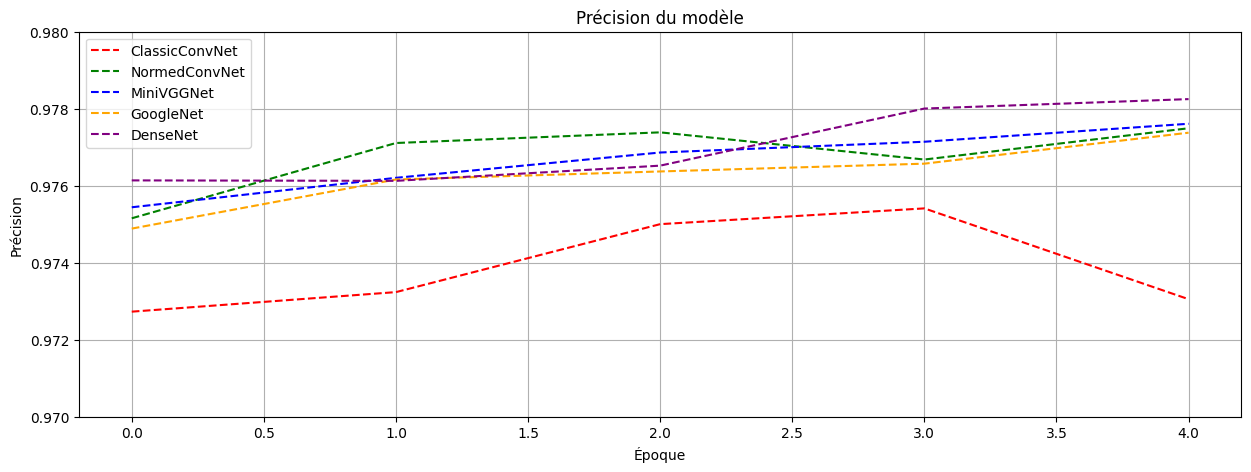

In [39]:
plot_accuracies(nets,history,names,[0.97,0.98])

L'accuracy est très élevé car, la plus grande partie des paquets sont classés comme normaux. Il faut donc regarder la matrice de confusion pour voir si les autres classes sont bien classées.

Normal classifier = 2'218'764 / 2'540'044 = 87.4%

23813/23813 [==============================] - 50s 2ms/step
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[6 6 6 ... 5 6 6]
[6 6 6 ... 5 6 6]


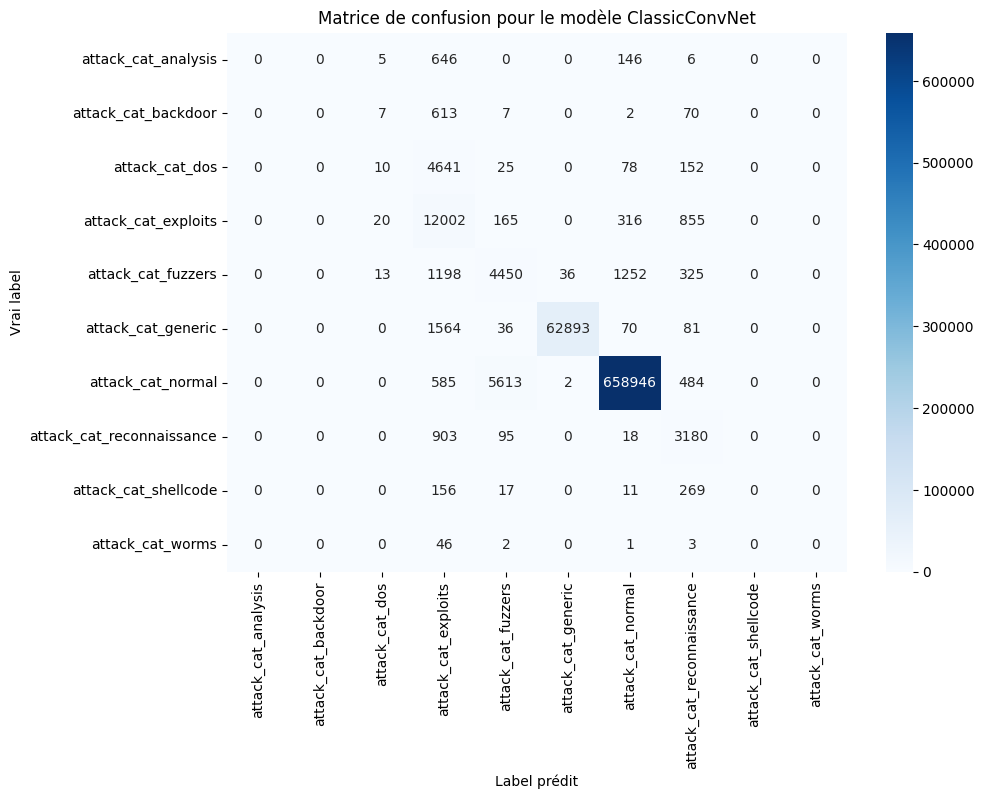

23813/23813 [==============================] - 40s 2ms/step
[[7.2905566e-15 1.8588267e-15 2.1235800e-11 ... 2.5479055e-16
  9.7217510e-20 3.4164415e-15]
 [1.1578637e-21 1.0874991e-24 9.8577370e-17 ... 1.4250819e-22
  4.7420195e-34 1.6415781e-24]
 [9.1441184e-17 1.2965408e-17 5.9703312e-11 ... 7.5432611e-19
  2.8628128e-28 1.2460384e-18]
 ...
 [4.5092815e-15 3.4398893e-15 1.2692145e-10 ... 1.3806795e-09
  3.9046080e-27 3.5103525e-26]
 [1.8115781e-26 4.3300606e-27 3.6383316e-18 ... 6.3324042e-23
  5.7770827e-37 6.9220380e-25]
 [1.2725420e-15 1.6333155e-15 3.9283821e-10 ... 5.8139739e-17
  3.6618995e-21 1.0177296e-15]]
[6 6 6 ... 5 6 6]
[6 6 6 ... 5 6 6]


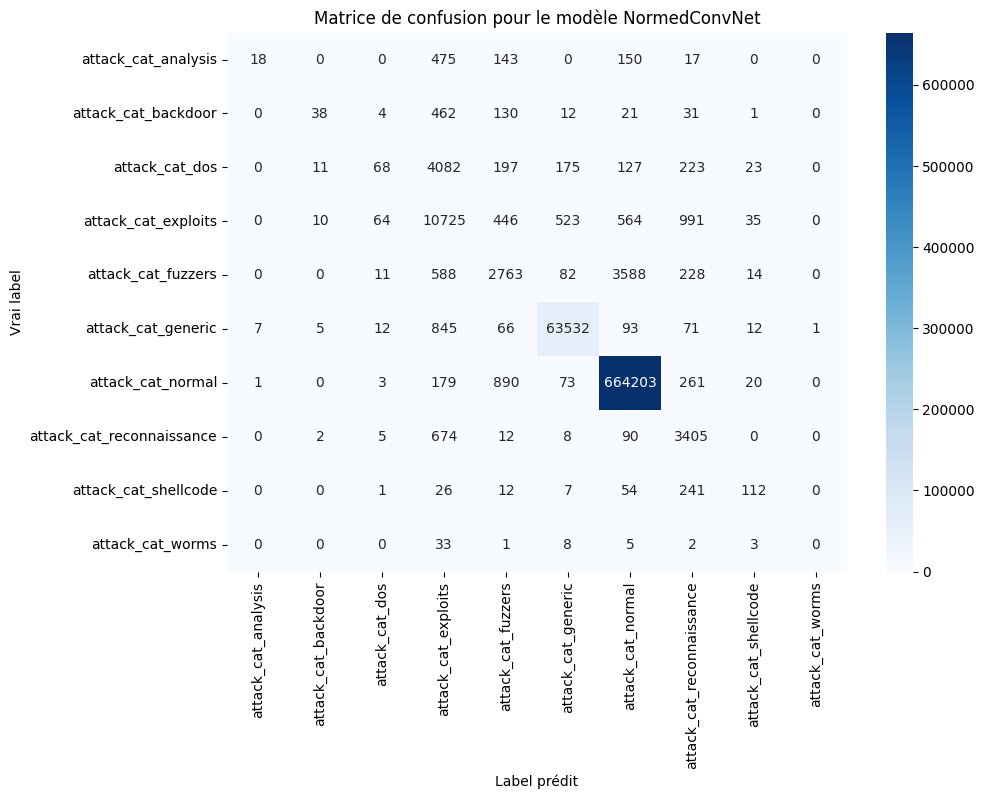

23813/23813 [==============================] - 44s 2ms/step
[[2.3618530e-07 1.6350954e-07 4.6950663e-06 ... 1.6975432e-06
  1.9373087e-07 6.1128823e-12]
 [3.7529063e-08 1.8632411e-09 4.1742467e-08 ... 2.5485527e-08
  1.7638759e-09 2.0260627e-12]
 [6.2695435e-08 1.9060399e-08 5.3805621e-07 ... 4.0448518e-07
  1.2284040e-08 1.0349571e-11]
 ...
 [1.6906115e-13 1.6128543e-13 1.4903398e-11 ... 1.6465922e-13
  2.3523715e-13 3.9525395e-13]
 [4.8012129e-08 5.7034608e-09 9.0673105e-08 ... 5.5425030e-08
  5.0943072e-09 2.0468397e-12]
 [1.2596594e-08 1.6626578e-09 4.1903164e-08 ... 1.4670334e-08
  5.2952354e-09 4.7130511e-12]]
[6 6 6 ... 5 6 6]
[6 6 6 ... 5 6 6]


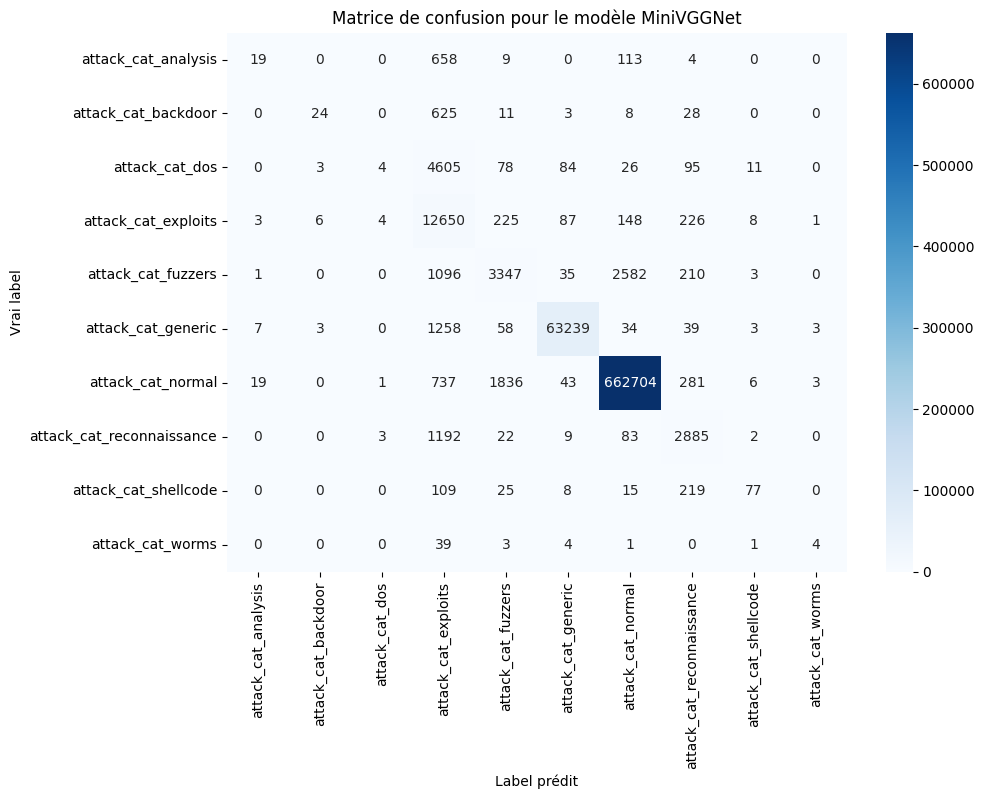

23813/23813 [==============================] - 43s 2ms/step
[[1.7131276e-11 1.8566492e-17 3.5266467e-11 ... 4.1177842e-12
  2.5115574e-21 1.5717457e-22]
 [3.5516591e-21 5.9258690e-30 9.0620439e-21 ... 1.6168045e-26
  1.2938562e-27 4.8857362e-28]
 [1.6330095e-16 4.7930739e-17 2.0469671e-13 ... 9.3753618e-18
  5.3259204e-28 8.8592837e-21]
 ...
 [2.1392896e-09 6.6516037e-09 9.4763159e-08 ... 1.2560376e-11
  4.9486778e-15 2.0286163e-17]
 [3.1284646e-20 3.9510865e-27 2.4955989e-21 ... 7.1231671e-22
  5.1696654e-28 8.2271276e-23]
 [1.7185952e-16 2.4249622e-20 2.7823899e-14 ... 5.8081912e-16
  2.2132602e-25 2.0285327e-24]]
[6 6 6 ... 5 6 6]
[6 6 6 ... 5 6 6]


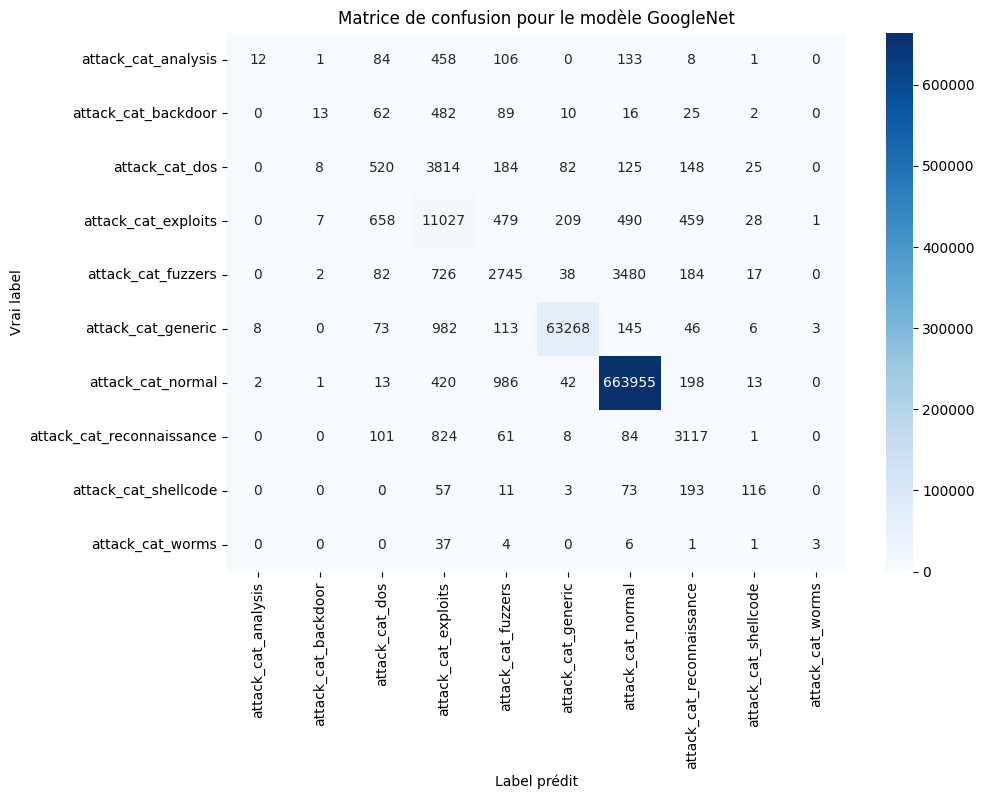

23813/23813 [==============================] - 43s 2ms/step
[[4.2662628e-20 3.9537593e-25 1.1546897e-18 ... 1.4078044e-19
  2.5539064e-11 2.9895787e-27]
 [2.9573997e-19 1.1040591e-26 2.7397304e-20 ... 3.3307255e-22
  3.0492258e-14 2.6444679e-29]
 [2.7591773e-19 3.7728166e-26 6.4645129e-18 ... 3.4702870e-20
  5.4804497e-15 8.3745029e-28]
 ...
 [4.6321816e-22 3.5654342e-23 2.5077522e-17 ... 8.9112662e-16
  5.6638588e-20 3.9985119e-21]
 [3.4146626e-19 5.6124835e-25 2.7188583e-18 ... 3.8066713e-20
  1.4152556e-13 7.2537109e-24]
 [9.9813868e-19 1.0825570e-24 3.6375426e-17 ... 7.0277362e-20
  8.9805340e-14 2.5065248e-27]]
[6 6 6 ... 5 6 6]
[6 6 6 ... 5 6 6]


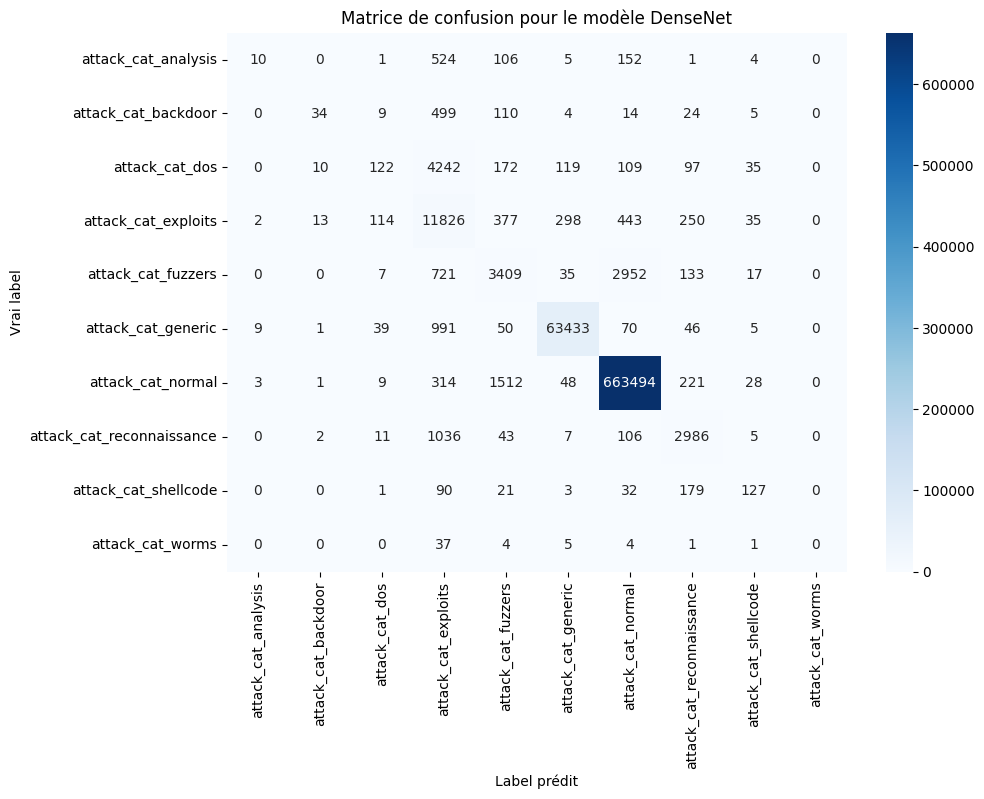

In [57]:
def plot_confusion_matrices(nets, names, x_test, y_test):
    accuracies = []  # Liste pour stocker les accuracies et les noms des architectures

    for net in range(nets):
        y_pred = model[net].predict(x_test)
        y_pred_classes = np.argmax(y_pred, axis=1)

        y_test_array = y_test.to_numpy()
        y_true_classes = np.argmax(y_test_array, axis=1)

        # Calcul de la matrice de confusion
        cm = confusion_matrix(y_true_classes, y_pred_classes)

        # Calcul de l'accuracy globale
        total_accuracy = np.trace(cm) / np.sum(cm) * 100
        accuracies.append((names[net], total_accuracy))

        # Calcul de l'accuracy pour chaque classe et création d'une nouvelle matrice pour l'affichage
        cm_sum = np.sum(cm, axis=1, keepdims=True)
        cm_perc = cm / cm_sum.astype(float) * 100
        annot = np.empty_like(cm).astype(str)
        nrows, ncols = cm.shape
        for i in range(nrows):
            for j in range(ncols):
                c = cm[i, j]
                p = cm_perc[i, j]
                if i == j:
                    s = cm_sum[i]
                    annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
                elif c == 0:
                    annot[i, j] = ''
                else:
                    annot[i, j] = '%.1f%%\n%d' % (p, c)

        # Tracer la matrice de confusion
        plt.figure(figsize=(10, 7))
        sns.heatmap(cm, annot=annot, fmt='', cmap=plt.cm.Blues, xticklabels=y_cols, yticklabels=y_cols)
        plt.title(f"Matrice de confusion pour le modèle {names[net]} - Accuracy: {total_accuracy:.2f}%")
        plt.ylabel('Vrai label')
        plt.xlabel('Label prédit')
        plt.show()

    # Tri des architectures par accuracy et affichage
    accuracies.sort(key=lambda x: x[1], reverse=True)
    print("Architectures triées par accuracy :")
    for name, accuracy in accuracies:
        print(f"{name}: {accuracy:.2f}%")

# Appeler la fonction après l'entraînement des modèles
plot_confusion_matrices(nets, names, x_test, y_test)

In [55]:
display(y_test)

,attack_cat_analysis,attack_cat_backdoor,attack_cat_dos,attack_cat_exploits,attack_cat_fuzzers,attack_cat_generic,attack_cat_normal,attack_cat_reconnaissance,attack_cat_shellcode,attack_cat_worms
1658613,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
173097,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2370537,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1877153,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2192534,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
340417,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1592289,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2504834,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
927437,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
